#  Experiment 8: Generalize Experiment 4 Source identification. (N-class classification.)
Compare Naive Bayes classifier to XGBoost.

Evaluate performance on a harder problem: identifying which source an image came from. This is harder than source verification, because you must decide which of N sources an image is from.   

**Caution**: with small # of distinct compression features (a few hundred), it's impossible to uniquely identify more than that number of sources.

In [17]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
import sys
import subprocess
import random
import pickle
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# from tqdm.autonotebook import tqdm
from tqdm.notebook import tqdm

from image_compression_attribution.common.code.models import quant_matrices, compr_levels
from image_compression_attribution.common.code.summarize_quant_matrices import summarize_compression_features

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 500)

from sklearn.metrics import make_scorer, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#WARNING: this method does not seem to work well when there are large gaps
#in the ROC curve. Hence, only use this if you have interpolated between
#ROC curve data points to fill in the roc curve on a grid with small intervals.
#https://github.com/scikit-learn/scikit-learn/issues/15247#issuecomment-542138349
def calculate_eer(fpr, tpr):
    '''
    Returns the equal error rate for a binary classifier output.
    '''
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

In [19]:
RND_SEED=1234
np.random.seed(RND_SEED)

In [20]:
SUMMARY_FILE = "/app/dataset/data.csv"

RESULTS_FOLDER = "results/exp_08"
os.makedirs(RESULTS_FOLDER, exist_ok=True)

df = pd.read_csv(SUMMARY_FILE)
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

#Drop non-image files, e.g. html files returned
#due to download errors

df, df_dropped = df[ df['mime'].str.startswith('image') ].reset_index(drop=True), \
  df[ ~df['mime'].str.startswith('image') ].reset_index(drop=True)

sources = sorted(list(df['source'].unique()))


In [21]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import IsolationForest
#Guide to LabelEncoder:  
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

import xgboost as xgb


#create numerical class labels for quantization categorical names (suitable for 
#use as  ML training feature vector)
le_qs = preprocessing.LabelEncoder()
le_qs.fit(df['q_name'])
df['q_name_class'] = le_qs.transform(df['q_name'])

sources = sorted(list(df['source'].unique()))
le_sources = preprocessing.LabelEncoder()
le_sources.fit(sources)
df['source_class'] = le_sources.transform(df['source'])

In [22]:
df

,articleUrl,articleHash,imageUrl,source,mime,compression,q_hash,q_name,timestamp,q_name_class,source_class
0,https://www.abc.net.au/news/2020-05-25/toowoomba-unemployment-hits-horrific-level/12282346,4de7b04b17622bc838468486216f9878,https://live-production.wcms.abc-cdn.net.au/10d55dfa1fef3ec5f4f20cdac0b64df5?impolicy=wcms_crop_resize&cropH=528&cropW=938&xPos=1&yPos=0&width=862&height=485,abc.net.au,image/webp,92,NaN,webp_092,2020-05-25 00:00:00+00:00,254,0
1,https://www.abc.net.au/news/2017-01-11/trade-war-between-us-and-china-a-major-threat-to-australia/8172562,99770eadd0f12e1c63df525a8c739f8c,https://live-production.wcms.abc-cdn.net.au/bcbaa4880d63e1b7c46ac95773583381?impolicy=wcms_crop_resize&cropH=1037&cropW=1851&xPos=0&yPos=0&width=862&height=485,abc.net.au,image/webp,92,NaN,webp_092,2017-01-11 00:00:00+00:00,254,0
2,https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128,90c0fcf3f9dd12d2770ac4092ca9f612,https://live-production.wcms.abc-cdn.net.au/28314158cc17db94d2062a7539d49fd9?impolicy=wcms_crop_resize&cropH=1515&cropW=2272&xPos=0&yPos=0&width=862&height=575,abc.net.au,image/webp,92,NaN,webp_092,2021-01-31 00:00:00+00:00,254,0
3,https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128,90c0fcf3f9dd12d2770ac4092ca9f612,https://live-production.wcms.abc-cdn.net.au/be7013fd935ad10ecd612700c2973c9b?impolicy=wcms_crop_resize&cropH=2250&cropW=2250&xPos=375&yPos=0&width=862&height=862,abc.net.au,image/webp,92,NaN,webp_092,2021-01-31 00:00:00+00:00,254,0
4,https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128,90c0fcf3f9dd12d2770ac4092ca9f612,https://live-production.wcms.abc-cdn.net.au/b639a168ddb98a55e2c46628278f6063?impolicy=wcms_crop_resize&cropH=2001&cropW=3000&xPos=0&yPos=0&width=862&height=575,abc.net.au,image/webp,92,NaN,webp_092,2021-01-31 00:00:00+00:00,254,0
...,...,...,...,...,...,...,...,...,...,...,...
64680,https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting,59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/DC772857-F881-4A9E-B36A-B693023E9514.jpg,voanews,image/jpeg,50,48c9be01d998be93be725587386b3028,jpeg_050_48c9b,2016-09-15 18:20:00+00:00,13,29
64681,https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting,59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/sourced_737px_wide/s3/2019-04/48F9FC10-1A1C-4D52-949E-93D7CA7AEF2A.png?itok=DnRzA_-G,voanews,image/webp,92,NaN,webp_092,2016-09-15 18:20:00+00:00,254,29
64682,https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting,59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/sourced_737px_wide/s3/2019-04/48F9FC10-1A1C-4D52-949E-93D7CA7AEF2A.png,voanews,image/webp,92,NaN,webp_092,2016-09-15 18:20:00+00:00,254,29
64683,https://www.voanews.com/usa/text-trump-kim-summit-agreement,a211274edc80df58940fa8d981593dcede819f348f3056f247303b03019f20b0,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/42E315BD-BBDD-4C79-BB40-387CAB29E6AB.jpg?itok=xnZSXjXB,voanews,image/jpeg,50,48c9be01d998be93be725587386b3028,jpeg_050_48c9b,2018-06-12 04:55:00+00:00,13,29


In [23]:
df_source_decoder = df[["source", "source_class"]].drop_duplicates().sort_values(by='source_class').reset_index(drop=True)
df_source_decoder

,source,source_class
0,abc.net.au,0
1,airforcetimes.com,1
2,aljazeera,2
3,allafrica.com,3
4,americanfreepress,4
5,asahi.com,5
6,bbc,6
7,canadiandimension,7
8,ceasefire,8
9,centurywire,9


In [24]:
import sklearn.metrics

#Prepare Train and Test Split.
#Do random sampling to make train/test split. 
PERCENT_TEST = 0.40


#Want to group images from articles:
# get articles (i.e. unique URLs)
ds_articles4 = df['articleHash'].drop_duplicates().reset_index(drop=True)

#So randomly sample articles to build train & test sets, e.g 60%/40% split
num_articles4 = len(ds_articles4)
num_test_articles4 = int(PERCENT_TEST*num_articles4)
test_articles4 = ds_articles4.sample(num_test_articles4)

num_train_articles4 = num_articles4 - num_test_articles4
train_articles4 = ds_articles4[~ds_articles4.isin(test_articles4)]

df_train4 = df[df['articleHash'].isin(train_articles4)]
df_test4 = df[df['articleHash'].isin(test_articles4)]
                             
#assert len(train_articles4) + len(test_articles4) == len(df)
assert len(df_train4) + len(df_test4) == len(df)

#-------------------------------------------------------------
#Fit model
sk_model = quant_matrices.attribution_quant_matrices_sk()
sk_model.fit( df_train4[['q_name_class']],  df_train4['source_class'] )

#make predictions
predicted_source_class4 = sk_model.model.predict(df_test4[['q_name_class']])

xgb_model_QM1f = xgb.XGBClassifier()
xgb_model_QM1f.fit(df_train4[['q_name_class']],  df_train4['source_class'])
predicted_source_class4_xgb = xgb_model_QM1f.predict(df_test4[['q_name_class']])

#-------------------------------------------------------------
#Compute accuracy

accuracy4 = sklearn.metrics.accuracy_score(df_test4['source_class'], predicted_source_class4, normalize=True)

accuracy4_xgb = sklearn.metrics.accuracy_score(df_test4['source_class'], predicted_source_class4_xgb, normalize=True)

print("overall accuracy (NB) = {}".format(accuracy4))
print("overall accuracy (XGB) = {}".format(accuracy4))

print("saving accuracy to file")
with open(os.path.join(RESULTS_FOLDER,"accuracy.txt"),"w") as file1:
  file1.write("{:.1f}".format(accuracy4*100))
  

/usr/local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
overall accuracy (NB) = 0.5315406075635462
overall accuracy (XGB) = 0.5315406075635462
saving accuracy to file


In [25]:
#confusion matrix:
confusion_m4 = sklearn.metrics.confusion_matrix(df_test4['source_class'], predicted_source_class4, labels=df_source_decoder['source_class'])
confusion_m4

array([[1365,    0,   23,    0,    3,    0,    0,   10,   18,    0,    2,
          20,    0,    0,    0,    0,    7,    0,    0,    0,    1,    0,
           0,   35,    0,    0,    5,    1,    3,    0],
       [ 168,    0,    4,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    8,    0,    0,    0,    0,    0,    0],
       [  13,    0, 1107,    4,   21,    0,    0,    0,   17,    0,    8,
           7,    0,    0,    0,    0,  208,    0,    0,    0,   73,    0,
           0,    0,   10,  152,   15,    2,    0,    0],
       [   0,    0,    0,   63,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   18,    0,  213,    0,    0,    9,  123,    0,    0,
           2,    0,    0,    0,    0,   36,    0,    0,    0,    0,    0,
           0,    0,    4,    7, 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
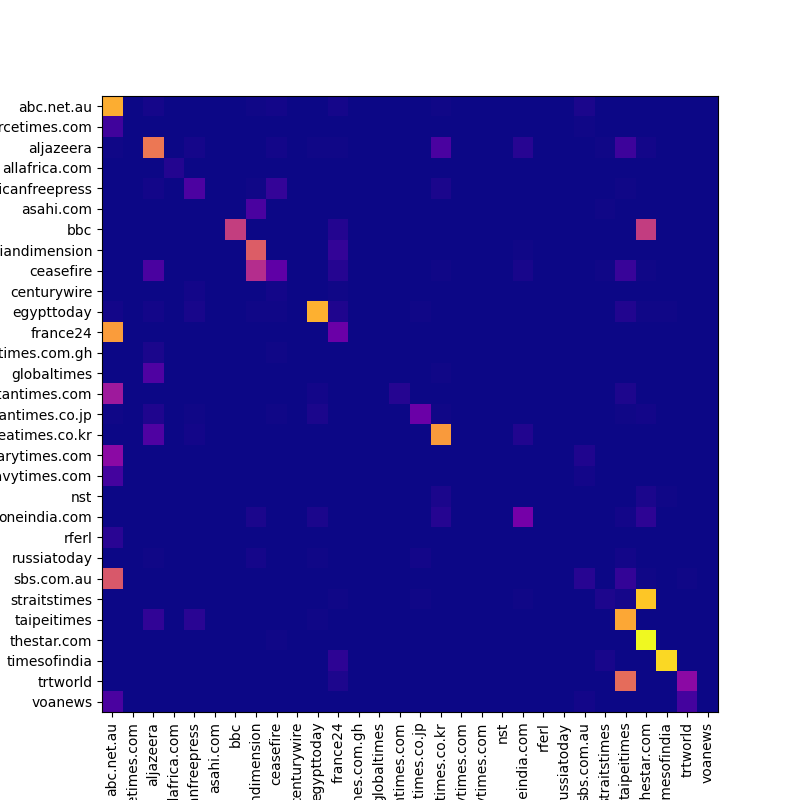

In [26]:
# visualize confusion matrix
fig, ax = plt.subplots(figsize=(8,8))
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_m4,
                              display_labels=df_source_decoder['source'])
disp.plot(xticks_rotation='vertical', cmap="plasma", ax=ax, include_values=False, colorbar=False) 
# plt.tight_layout()
plt.show()
#uncomment to save:
plt.savefig(os.path.join(RESULTS_FOLDER,"confusion_matrix.pdf"), bbox_inches='tight')

### Observations:
* not bad overall (pretty diagonal) but some confusions

# Extra experiment: see how accuracy drops with # of sources
Keep first first k sources and compute accuracy.  Sweep through k values, e.g. 5 to 30.

In [ ]:
#Prepare Train and Test Split.
#Do random sampling to make train/test split. 
PERCENT_TEST = 0.40

num_sources_list = []
accuracy_list = []
accuracy_list_xgb = []

for num_sources in range(5, len(df['source'].unique())+1): 
  df_tmp = df[df['source'].isin(sources[0:num_sources])]
  
  assert len(df_tmp['source'].unique()) == num_sources
  
  #Want to group images from articles:
  # get articles (i.e. unique URLs)
  ds_articles4 = df_tmp['articleHash'].drop_duplicates().reset_index(drop=True)

  #So randomly sample articles to build train & test sets, e.g 60%/40% split
  num_articles4 = len(ds_articles4)
  num_test_articles4 = int(PERCENT_TEST*num_articles4)
  test_articles4 = ds_articles4.sample(num_test_articles4)

  num_train_articles4 = num_articles4 - num_test_articles4
  train_articles4 = ds_articles4[~ds_articles4.isin(test_articles4)]

  df_train4 = df_tmp[df_tmp['articleHash'].isin(train_articles4)]
  df_test4 = df_tmp[df_tmp['articleHash'].isin(test_articles4)]

  #assert len(train_articles4) + len(test_articles4) == len(df)
  assert len(df_train4) + len(df_test4) == len(df_tmp)

  #-------------------------------------------------------------
  #Fit model
  sk_model = quant_matrices.attribution_quant_matrices_sk()
  sk_model.fit( df_train4[['q_name_class']],  df_train4['source_class'] )

  #make predictions
  predicted_source_class4 = sk_model.model.predict(df_test4[['q_name_class']])
  
  xgb_model_QM1f = xgb.XGBClassifier()
  xgb_model_QM1f.fit(df_train4[['q_name_class']],  df_train4['source_class'])
  predicted_source_class4_xgb = xgb_model_QM1f.predict(df_test4[['q_name_class']])

  #-------------------------------------------------------------
  #Compute accuracy

  accuracy4 = sklearn.metrics.accuracy_score(df_test4['source_class'], predicted_source_class4, normalize=True)
  
  accuracy4_xgb = sklearn.metrics.accuracy_score(df_test4['source_class'], predicted_source_class4_xgb, normalize=True)

  print("Run experiment with {} sources: NB accuracy {},  XGB accuracy {}".format(num_sources, accuracy4, accuracy4_xgb))
  num_sources_list.append(num_sources)
  accuracy_list.append(accuracy4)
  accuracy_list_xgb.append(accuracy4_xgb)
  

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
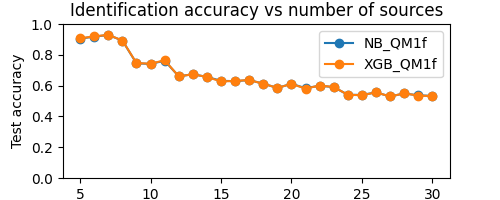

In [28]:
x_num_sources = np.array(num_sources_list)
y_accuracy = np.array(accuracy_list)
y_accuracy_xgb = np.array(accuracy_list_xgb)

# plt.figure(figsize=(6,5))
plt.figure(figsize=(5,2))
plt.plot(x_num_sources, y_accuracy, 'o-', label="NB_QM1f")
plt.plot(x_num_sources, y_accuracy_xgb, 'o-', label="XGB_QM1f")
plt.ylim(0,1)
plt.ylabel("Test accuracy")
plt.title("Identification accuracy vs number of sources")
plt.legend()
#uncomment to save:
plt.savefig(os.path.join(RESULTS_FOLDER,"accuracy_vs_num_sources.pdf"), bbox_inches='tight')

## Conclusion: XGBoost and Naive Bayes models performed the same